In [45]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statistics
import pickle

# Train & Test
# ==============================================================================
from sklearn.model_selection import train_test_split

# Proyección
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [46]:
df=pd.read_csv("datos/train_preproc_robust_onehot_map.csv",index_col=0)

In [47]:
df.head()

,carat,depth,table,x,y,z,price,clarity_ord,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,-0.625000,0.400000,0.333333,-0.754098,-0.780220,-0.750000,6.353,2,0,0,0,1,0,1,0,0,0,0,0,0
1,0.484375,0.600000,-0.333333,0.398907,0.417582,0.464286,9.183,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0.031250,0.000000,0.666667,0.010929,0.021978,0.017857,7.983,1,0,0,1,0,0,0,0,1,0,0,0,0
3,0.593750,0.933333,0.000000,0.464481,0.439560,0.535714,8.371,2,0,0,0,0,1,0,0,0,1,0,0,0
4,-0.531250,0.333333,0.666667,-0.650273,-0.631868,-0.625000,6.588,1,0,0,0,1,0,0,0,0,1,0,0,0


In [63]:
df.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'clarity_ord',
       'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J'],
      dtype='object')

In [48]:
# Reparto de datos en train y test
# ==============================================================================
# lo primero que hacemos es definir cual es nuestra variable Y y nuestras variables X
X = df.drop('price', axis =1)
y = df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [49]:
df.head(1)

,carat,depth,table,x,y,z,price,clarity_ord,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,-0.625,0.4,0.333333,-0.754098,-0.78022,-0.75,6.353,2,0,0,0,1,0,1,0,0,0,0,0,0


In [50]:
print("Datos de entrenamiento")
print("-----------------------")
print(y_train.describe())
print("Datos de testeo")
print("-----------------------")
print(y_test.describe())

Datos de entrenamiento
-----------------------
count    32348.000000
mean         7.786322
std          1.015895
min          5.814000
25%          6.855000
50%          7.782000
75%          8.577000
max          9.842000
Name: price, dtype: float64
Datos de testeo
-----------------------
count    8087.000000
mean        7.771408
std         1.019746
min         5.787000
25%         6.837500
50%         7.767000
75%         8.590500
max         9.842000
Name: price, dtype: float64


In [51]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [52]:
# max features

max_features = np.sqrt(len(X_train.columns))
max_features

4.358898943540674

In [53]:
# max depth

max_depth = regressor.tree_.max_depth
max_depth

44

In [54]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [55]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [56]:
# sacamos las métricas para ver si hay overfitting

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.126458,0.030827,0.175576,0.970352,test,Decission Tree I
1,0.000442,0.000046,0.006760,0.999956,train,Decission Tree I


In [57]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4,6,8,10,12,14,16,18],
        "min_samples_split": [500,600,700,800],
        "min_samples_leaf": [500,600,700,800],
        "max_features": [1,2,3,4,5]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [58]:
# ajustamos el modelo de nuevo

%time
gs.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [500, 600, 700, 800],
                         'min_samples_split': [500, 600, 700, 800]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=18, max_features=5, min_samples_leaf=500,
                      min_samples_split=500)

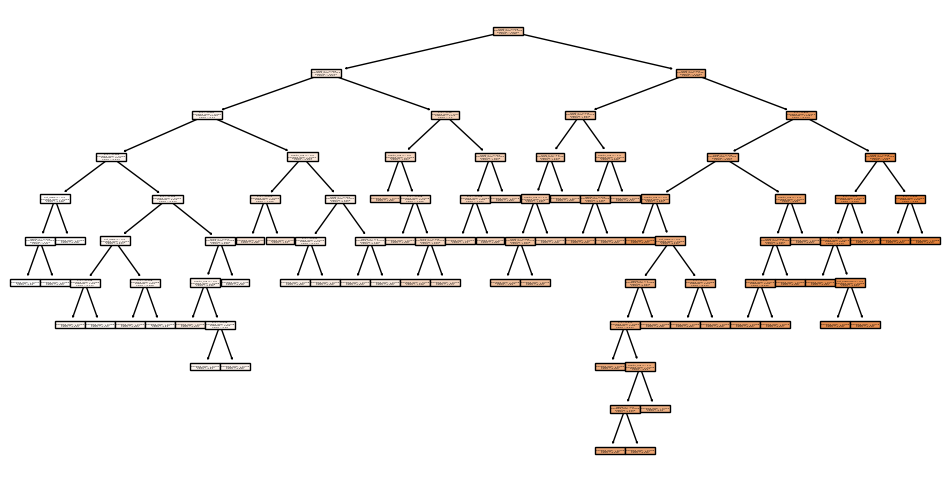

In [60]:
# volvamos a intentar visualizar el árbol a ver como se ve: 

fig = plt.figure(figsize=(12, 6))
tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True);

In [61]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.175072,0.049725,0.222991,0.952176,test,Decision tree II
1,0.173621,0.048750,0.220793,0.952762,train,Decision tree II


In [62]:
with open(f'datos/decissiontree1.pkl', 'wb') as decissiontree1:
        pickle.dump(regressor, decissiontree1)